In [2]:
import os
import librosa
import soundfile as sf
import numpy as np
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model, Wav2Vec2FeatureExtractor
from typing import List, Tuple
import subprocess
from tqdm import tqdm
from scipy.spatial.distance import cosine
from IPython.display import Audio, display
import random
from matplotlib import pyplot as plt

In [3]:
result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [4]:
processor = Wav2Vec2FeatureExtractor.from_pretrained("facebook/wav2vec2-large-xlsr-53")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-large-xlsr-53").eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/root/miniconda3/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


Wav2Vec2Model(
  (feature_extractor): Wav2Vec2FeatureEncoder(
    (conv_layers): ModuleList(
      (0): Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (1-4): 4 x Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (5-6): 2 x Wav2Vec2LayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): Wav2Vec2FeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=1024, bias=True)
    (dropout)

In [5]:
T_win = 0.5 
T_hop = 0.25 
def load_and_resample(path: str, target_sr=16000) -> np.ndarray:
    audio, sr = librosa.load(path, sr=None)
    if sr != target_sr:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
    print(f"Loaded and resampled audio from {path} to {target_sr} Hz.")
    return audio

def segment_audio(audio: np.ndarray, sample_rate: int, win_sec: float = T_win, hop_sec: float = T_hop) -> List[np.ndarray]:
    win_size = int(sample_rate * win_sec)
    hop_size = int(sample_rate * hop_sec)
    segments = []
    for start in range(0, len(audio) - win_size + 1, hop_size):
        segment = audio[start:start + win_size]
        segments.append(segment)
    print(f"Segmented audio into {len(segments)} segments.")
    return segments


In [6]:
def extract_wav2vec_features(segments: List[np.ndarray]) -> List[np.ndarray]:
    features = []
    for seg in tqdm(segments, desc="Extracting features", leave=False):
        inputs = processor(seg, sampling_rate=16000, return_tensors="pt", padding=True)
        input_values = inputs.input_values.to(device)
        with torch.no_grad():
            outputs = model(input_values, output_hidden_states=True)
            #hidden_states = model(input_values).last_hidden_state  # shape: (1, time, 768)
            mean_feat = outputs.hidden_states[4].mean(dim=1).squeeze(0).cpu().numpy()  # shape: (768,)
            features.append(mean_feat)
    return features


In [7]:
def process_audio_file(path: str, output_dir: str, clip_id_prefix: str):
    os.makedirs(output_dir, exist_ok=True)
    audio = load_and_resample(path)
    segments = segment_audio(audio, 16000, win_sec=T_win, hop_sec=T_hop)
    features = extract_wav2vec_features(segments)

    for i, (seg, feat) in tqdm(enumerate(zip(segments, features)), total=len(segments), desc="Saving clips and features"):
        seg_path = os.path.join(output_dir, f"{clip_id_prefix}_{i:03d}.wav")
        feat_path = os.path.join(output_dir, f"{clip_id_prefix}_{i:03d}.npy")
        sf.write(seg_path, seg, 16000)
        np.save(feat_path, feat)

    print(f"Saved {len(segments)} clips and features to {output_dir}")
    return len(segments)

In [8]:
print(np.__version__)
input_audio = "../data/processed_clean/deep_clean.wav"
output_folder = "../data/processed_cliped/deep_clips"
max_index = process_audio_file(input_audio, output_folder, "deep")


1.26.4
Loaded and resampled audio from ../data/processed_clean/deep_clean.wav to 16000 Hz.
Segmented audio into 9 segments.


Saving clips and features: 100%|██████████| 9/9 [00:00<00:00, 1241.82it/s]

Saved 9 clips and features to ../data/processed_cliped/deep_clips


In [9]:
def play_audio(waveform, sr=16000):
    display(Audio(data=waveform, rate=sr))

def load_feature(folder, name, idx):
    path = os.path.join(folder, f"{name}_{idx:03d}.npy")
    return np.load(path)

def load_audio(folder, name, idx):
    path = os.path.join(folder, f"{name}_{idx:03d}.wav")
    y, sr = sf.read(path)
    return y, sr

In [10]:
def find_most_similar_pair(feature_dir1, feature_dir2, name1, name2, max_index1, max_index2, trials=10000):
    max_sim = -1
    xp, yp = 0, 0

    for _ in range(trials):
        x = random.randint(0, max_index1)
        y = random.randint(0, max_index2)
        if np.abs(x - y) < 10:
            continue
        y=6

        try:
            v1 = load_feature(feature_dir1, name1, x)
            v2 = load_feature(feature_dir2, name2, y)
        except FileNotFoundError:
            continue


        sim = 1 - cosine(v1, v2)  # cosine similarity
        if sim > max_sim:
            max_sim = sim
            xp, yp = x, y

    print(f"\nMax similarity: {max_sim:.4f} between trump_{xp:03d} and qimeidi_{yp:03d}")
    
    y1, sr1 = load_audio(feature_dir1, name1, xp)
    y2, sr2 = load_audio(feature_dir2, name2, yp)

    print("\n▶ Playing most similar clip 1:")
    play_audio(y1, sr1)

    print("\n▶ Playing most similar clip 2:")
    play_audio(y2, sr2)

feature_dir1 = "../data/processed_cliped/trump_clips"
feature_dir2 = "../data/processed_cliped/deep_clips"
max_index1 = 5000
max_index2 = 800
find_most_similar_pair(feature_dir1, feature_dir2, "trump", "deep", max_index1, max_index2, trials=10000)


Max similarity: 0.9324 between trump_736 and qimeidi_006

▶ Playing most similar clip 1:



▶ Playing most similar clip 2:


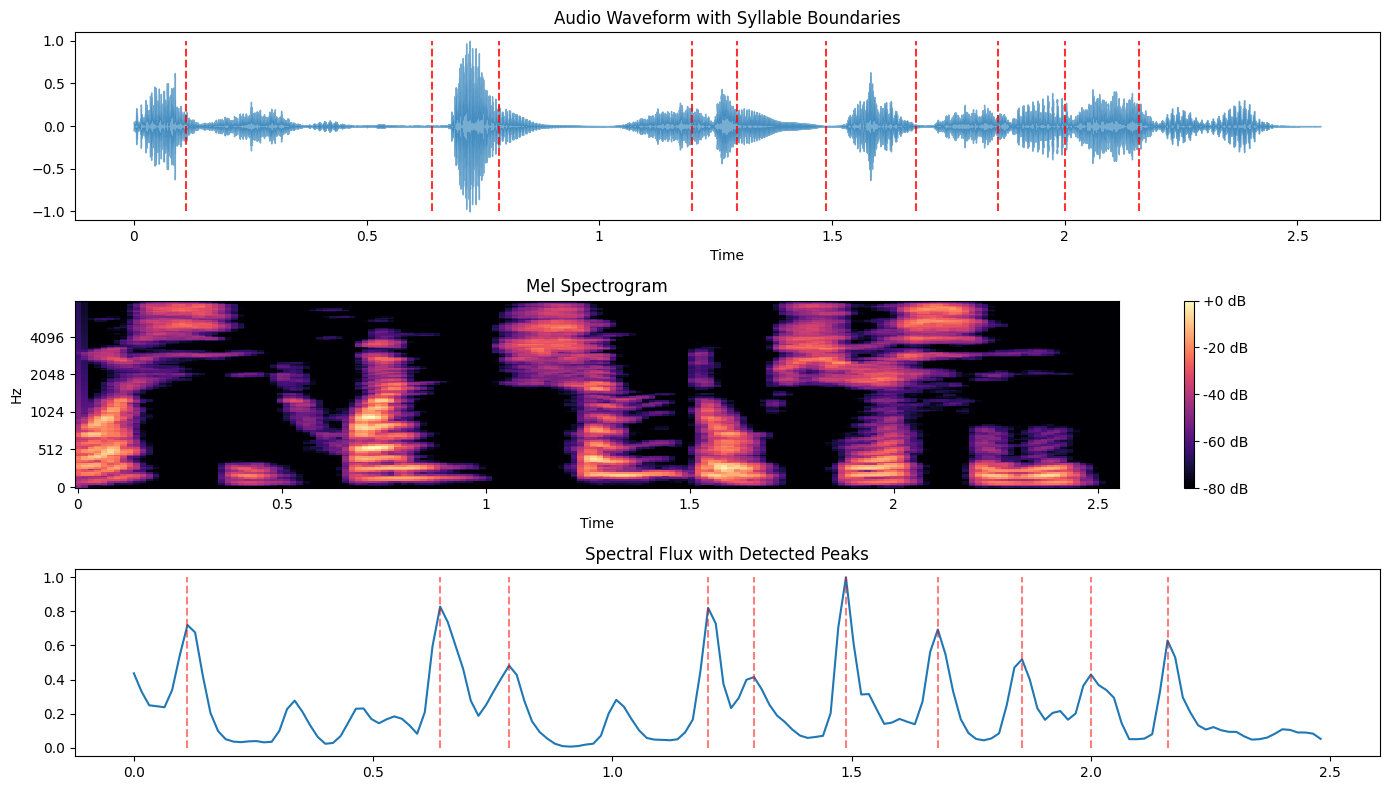

Detected syllable boundaries (seconds): [0.112 0.64  0.784 1.2   1.296 1.488 1.68  1.856 2.    2.16 ]


In [11]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def detect_syllable_boundaries(audio_path, sr=16000, plot=True):
    """基于频谱峰值检测音节边界
    
    参数:
        audio_path: 音频文件路径
        sr: 采样率 (默认16kHz)
        plot: 是否可视化结果
    """
    # 1. 加载音频
    y, sr = librosa.load(audio_path, sr=sr)
    
    # 2. 提取Mel频谱 (比MFCC更适合音节检测)
    S = librosa.feature.melspectrogram(
        y=y, 
        sr=sr,
        n_fft=1024,
        hop_length=256,
        n_mels=128,
        fmax=8000
    )
    log_S = librosa.power_to_db(S, ref=np.max)  # 转换为dB单位

    # 3. 计算频谱通量(Spectral Flux) - 检测频谱变化
    spectral_flux = np.sum(np.diff(log_S, axis=1)**2, axis=0)
    spectral_flux = np.insert(spectral_flux, 0, 0)  # 保持长度一致

    # 4. 平滑并归一化
    flux_smooth = librosa.util.normalize(
        np.convolve(spectral_flux, np.hanning(5), mode='valid')
    )

    # 5. 峰值检测 (关键参数调整点)
    peaks, _ = find_peaks(
        flux_smooth,
        height=np.mean(flux_smooth) + 0.5 * np.std(flux_smooth),  # 高度阈值
        distance=int(0.1 * sr / 256)  # 最小间隔0.1秒
    )
    
    # 转换为时间戳
    times = librosa.frames_to_time(peaks, sr=sr, hop_length=256)
    
    # 6. 可视化
    if plot:
        plt.figure(figsize=(14, 8))
        
        # 波形图
        plt.subplot(3, 1, 1)
        librosa.display.waveshow(y, sr=sr, alpha=0.6)
        plt.vlines(times, -1, 1, color='r', linestyle='--', alpha=0.8)
        plt.title('Audio Waveform with Syllable Boundaries')
        
        # 频谱图
        plt.subplot(3, 1, 2)
        librosa.display.specshow(log_S, sr=sr, hop_length=256, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel Spectrogram')
        
        # 频谱通量
        plt.subplot(3, 1, 3)
        plt.plot(librosa.frames_to_time(range(len(flux_smooth)), sr=sr, hop_length=256), 
                flux_smooth, label='Spectral Flux')
        plt.vlines(times, 0, 1, color='r', linestyle='--', alpha=0.5)
        plt.title('Spectral Flux with Detected Peaks')
        plt.tight_layout()
        plt.show()

    return times

# 使用示例
boundaries = detect_syllable_boundaries("../data/processed_clean/deep_clean.wav")
print("Detected syllable boundaries (seconds):", boundaries)

🔊 Unsupervised Segmentation
🚀 Loading audio: ../data/processed_clean/qimeidi_clean.wav
🔍 Extracting embeddings...
📐 Embedding shape: (10628, 1024)
🧠 Computing change signal...
📌 Detecting boundaries...
🧩 Found 84 boundaries
💾 Saving segments...
🔪 Cutting into 85 segments
📊 Plotting results...


/tmp/ipykernel_22169/4152096606.py:53: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


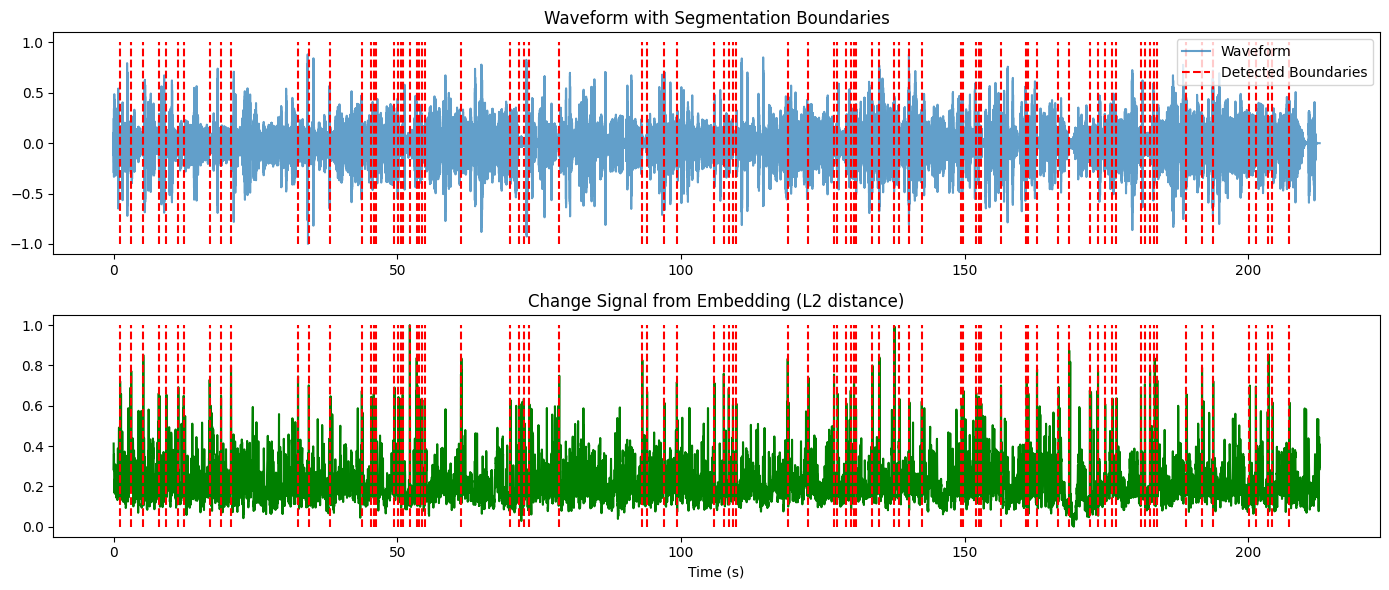

In [17]:

def extract_embeddings(audio: np.ndarray, sr=16000) -> np.ndarray:
    inputs = processor(audio, sampling_rate=sr, return_tensors="pt", padding=True)
    input_values = inputs.input_values.to(model.device)

    with torch.no_grad():
        outputs = model(input_values, output_hidden_states=True)            
        hidden_states = outputs.hidden_states[5].squeeze(0)  # (T, D)

    return hidden_states.cpu().numpy()

def compute_change_signal(embeddings: np.ndarray) -> np.ndarray:
    """Compute L2 or cosine distance between consecutive frames"""
    diffs = np.linalg.norm(np.diff(embeddings, axis=0), axis=1)
    diffs = (diffs - np.min(diffs)) / (np.max(diffs) - np.min(diffs) + 1e-6)  # normalize
    return diffs

def detect_boundaries(change_signal: np.ndarray, threshold=0.6, distance=5) -> np.ndarray:
    """Use peak detection to find segmentation boundaries"""
    peaks, _ = find_peaks(change_signal, height=threshold, distance=distance)
    return peaks

def segment_audio_by_boundaries(audio: np.ndarray, sr: int, boundaries: np.ndarray, frame_duration=0.02, output_dir="segments"):
    os.makedirs(output_dir, exist_ok=True)
    frame_samples = int(sr * frame_duration)

    time_boundaries = (boundaries * frame_samples).astype(int)
    time_boundaries = np.concatenate(([0], time_boundaries, [len(audio)]))

    print(f"🔪 Cutting into {len(time_boundaries)-1} segments")

    for i in range(len(time_boundaries) - 1):
        start = time_boundaries[i]
        end = time_boundaries[i + 1]
        segment = audio[start:end]
        if len(segment) > sr * 0.2:  # at least 200ms
            sf.write(os.path.join(output_dir, f"seg_{i:03d}.wav"), segment, sr)

def plot_segmentation(audio: np.ndarray, change_signal: np.ndarray, boundaries: np.ndarray, sr=16000, frame_duration=0.02):
    plt.figure(figsize=(14, 6))
    times = np.linspace(0, len(audio) / sr, num=len(change_signal))

    plt.subplot(2, 1, 1)
    plt.plot(np.linspace(0, len(audio)/sr, len(audio)), audio, label="Waveform", alpha=0.7)
    plt.vlines(boundaries * frame_duration, ymin=-1, ymax=1, color='r', linestyle='--', label="Detected Boundaries")
    plt.title("Waveform with Segmentation Boundaries")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(times, change_signal, label="Embedding Jump Signal", color='g')
    plt.vlines(boundaries * frame_duration, ymin=0, ymax=1, color='r', linestyle='--')
    plt.title("Change Signal from Embedding (L2 distance)")
    plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()

def run_unsupervised_segmentation(audio_path: str, output_dir: str):
    print(f"🚀 Loading audio: {audio_path}")
    y, sr = librosa.load(audio_path, sr=16000)

    print("🔍 Extracting embeddings...")
    embeddings = extract_embeddings(y, sr)
    print(f"📐 Embedding shape: {embeddings.shape}")

    print("🧠 Computing change signal...")
    change_signal = compute_change_signal(embeddings)

    print("📌 Detecting boundaries...")
    boundaries = detect_boundaries(change_signal, threshold=0.6, distance=15)
    print(f"🧩 Found {len(boundaries)} boundaries")

    print("💾 Saving segments...")
    segment_audio_by_boundaries(y, sr, boundaries, output_dir=output_dir)

    print("📊 Plotting results...")
    plot_segmentation(y, change_signal, boundaries, sr=sr)

# Example usage
if __name__ == "__main__":
    print("🔊 Unsupervised Segmentation")
    input_audio = "../data/processed_clean/qimeidi_clean.wav"  # 替换成你自己的文件路径
    output_dir = "../data/processed_cliped/qimeidi_clips"
    run_unsupervised_segmentation(input_audio, output_dir)